In [1]:
# Initial Load - let's just do 2022 data. 2020 might be skewed, covid.

For the given scenario of recommending airlines based on flight attributes (flight, departure city, arrival city, departure time) without individual preferences or historical traveler data, the approach will involve two main strategies:

### 1. Association Mining 
For the association mining part, the aim is to uncover associations between airports, specific times of the day, and preferred airlines. By utilizing association mining techniques, such as Apriori or FP-growth, patterns in the dataset can be revealed. For example, the analysis might discover that between Chicago O'Hare International Airport (ORD) and John F. Kennedy International Airport (JFK) during morning hours, a significant number of passengers tend to choose a particular airline or a set of airlines. This could reveal preferences or frequent choices based on the time of day or specific routes, assisting in understanding traveler behavior in terms of airline selections for different routes and times.


### 2. Graph based analysis
In the graph-based analysis, delays will be integrated as attributes within the network representation. Delays can be included as weighted edges, where the weights represent the average delay times between airports or airlines. Additionally, nodes in the graph could represent airports, and associated attributes might include delay-related statistics such as average delay times or delay frequency. Utilizing graph algorithms like centrality measures or community detection methods considering delay attributes can help discern how delays spread across the network and which nodes or airports are more central or influential in propagating delays.






### Association Mining

Step 1: Data Loading and Preprocessing

- Loaded flight data into a Spark DataFrame from a specific data path.
- Conducted initial data preprocessing by removing rows with missing values (dropna()).

Step 2: Correlation Analysis

- Selected numeric columns of interest from the dataset.
- Utilized Spark's MLlib to compute the correlation matrix between these numeric columns.
- Visualized the correlation matrix as a heatmap using Seaborn and Matplotlib to understand relationships between numeric attributes.

Step 3: Identifying Highly Correlated Pairs

- Identified highly correlated pairs among numeric columns based on a correlation threshold of 0.95.
- Generated pairs showing strong correlations to understand interdependencies between attributes.

Step 4: Feature Importance Analysis

- Selected relevant categorical and numerical columns for feature importance analysis.
- Indexed categorical columns and assembled features using VectorAssembler.
- Skipped building a Random Forest Regression model but directly extracted feature importance scores using a pre-existing model or the extracted correlations.

Step 5: Association Mining Analysis
- discovering frequent co-occurrences or patterns between items within transactions, providing insights into relationships between various attributes.


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns

spark = SparkSession.builder.appName("FlightDataAnalysis").config("spark.driver.memory", "4g").getOrCreate()

# Load flight data into a Spark DataFrame
data_path = "gs://msca-bdp-student-gcs/Group4_Final_Project/archive/Combined_Flights_2022.csv"
data = spark.read.csv(data_path, header=True, inferSchema=True)

# Data preprocessing (replace this with your specific cleaning logic)
# Example: Remove rows with missing values
data_cleaned = data.dropna()


In [4]:
# Print the schema of the DataFrame
data_cleaned.printSchema()


root
 |-- FlightDate: string (nullable = true)
 |-- Airline: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Cancelled: boolean (nullable = true)
 |-- Diverted: boolean (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- DepTime: double (nullable = true)
 |-- DepDelayMinutes: double (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- ArrTime: double (nullable = true)
 |-- ArrDelayMinutes: double (nullable = true)
 |-- AirTime: double (nullable = true)
 |-- CRSElapsedTime: double (nullable = true)
 |-- ActualElapsedTime: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Quarter: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Marketing_Airline_Network: string (nullable = true)
 |-- Operated_or_Branded_Code_Share_Partners: string (nullable = true)


In [7]:
#we can also drop duplicates, as one of them would represent one specific pathway:
original_row_count = data_cleaned.count()

# Remove duplicates
data_cleaned = data_cleaned.dropDuplicates()

# Count the number of rows after removing duplicates
new_row_count = data_cleaned.count()

# Print the results
print(f"Number of rows before removing duplicates: {original_row_count}")
print(f"Number of rows after removing duplicates: {new_row_count}")


23/11/22 20:27:31 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Number of rows before removing duplicates: 3944916
Number of rows after removing duplicates: 3944916


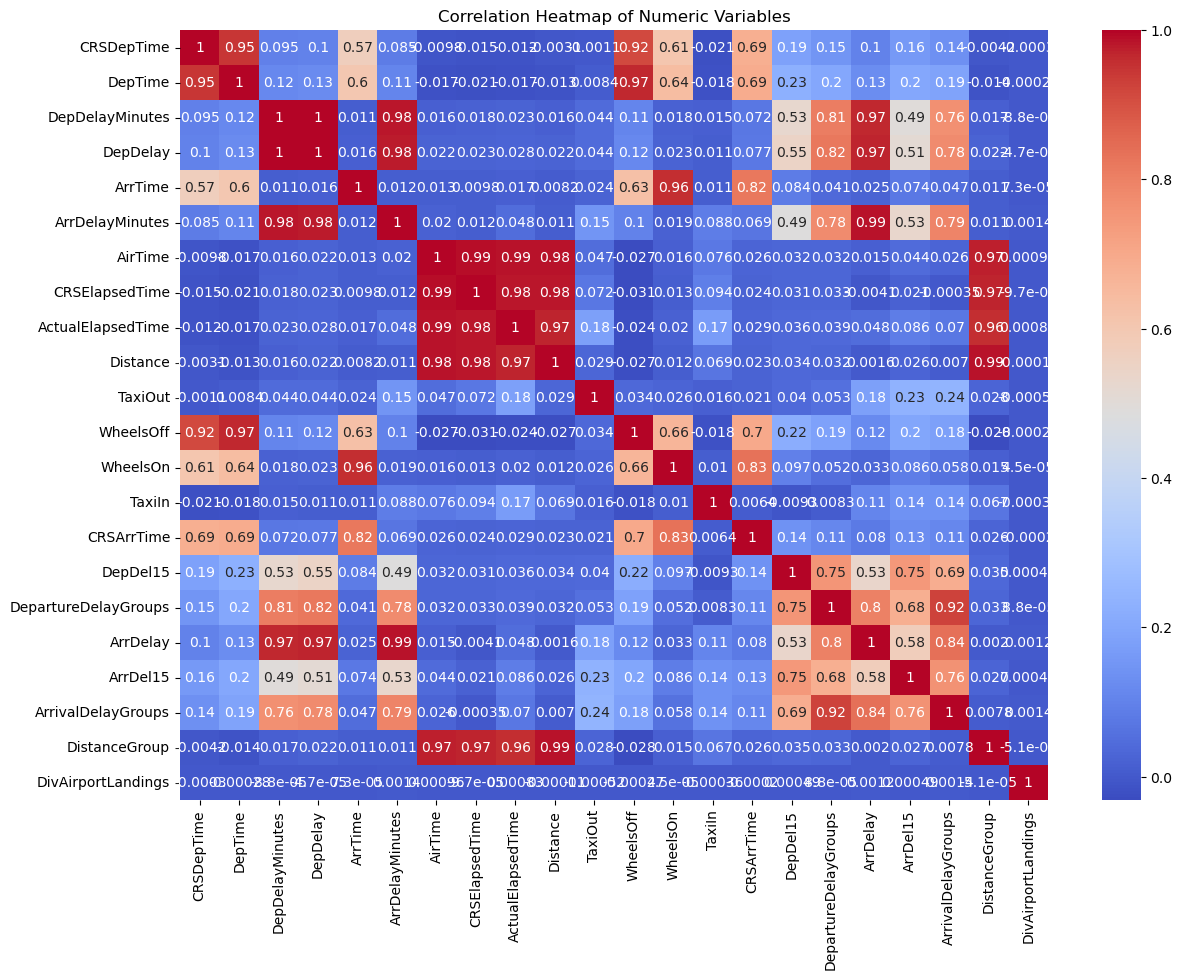

In [8]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric variables
numeric_columns = ['CRSDepTime', 'DepTime', 'DepDelayMinutes', 'DepDelay', 'ArrTime', 'ArrDelayMinutes',
                    'AirTime', 'CRSElapsedTime', 'ActualElapsedTime', 'Distance', 'TaxiOut', 'WheelsOff',
                    'WheelsOn', 'TaxiIn', 'CRSArrTime', 'DepDel15', 'DepartureDelayGroups', 'ArrDelay',
                    'ArrDel15', 'ArrivalDelayGroups', 'DistanceGroup', 'DivAirportLandings']

numeric_data = data_cleaned.select(numeric_columns)

# Assemble features into a single vector column
assembler = VectorAssembler(inputCols=numeric_columns, outputCol='features')
assembled_data = assembler.transform(numeric_data)

# Compute the correlation matrix
correlation_matrix = Correlation.corr(assembled_data, 'features').head()

# Extract the correlation matrix as a dense matrix
corr_matrix = correlation_matrix[0].toArray()

# Create a heatmap using seaborn
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', xticklabels=numeric_columns, yticklabels=numeric_columns)
plt.title('Correlation Heatmap of Numeric Variables')
plt.show()


Ok, from this we see certain things:
Some are the same thing - one is binary variable, categorical variable. 

i.e DepDelay, and DepDelayMinutes. 
i.e ArrDelay, and ArrDelay Minutes.

In this particular instance (where correlation is > 0.95), we will eliminate the variable that is binary.

Additionally, there are some variables that will be more beneficial if clustered. 


In [9]:
# Get the number of columns in the correlation matrix
num_columns = len(numeric_columns)

# Find pairs with correlation coefficient above 0.95
highly_correlated_pairs = []
for i in range(num_columns):
    for j in range(i + 1, num_columns):
        correlation = corr_matrix[i, j]
        if abs(correlation) > 0.95:  # Checking absolute correlation value
            pair = (numeric_columns[i], numeric_columns[j], correlation)
            highly_correlated_pairs.append(pair)

# Output pairs with correlation above 0.95
if len(highly_correlated_pairs) > 0:
    print("Pairs with correlation above 0.95:")
    for pair in highly_correlated_pairs:
        col1, col2, correlation = pair
        print(f"{col1} - {col2}: {correlation}")
else:
    print("No pairs found with correlation above 0.95")




Pairs with correlation above 0.95:
DepTime - WheelsOff: 0.9672081511551696
DepDelayMinutes - DepDelay: 0.99792581645247
DepDelayMinutes - ArrDelayMinutes: 0.9803966716566509
DepDelayMinutes - ArrDelay: 0.966518382465762
DepDelay - ArrDelayMinutes: 0.9771679373149912
DepDelay - ArrDelay: 0.9683457649442977
ArrTime - WheelsOn: 0.9586808226486914
ArrDelayMinutes - ArrDelay: 0.986319076265236
AirTime - CRSElapsedTime: 0.9894365180656598
AirTime - ActualElapsedTime: 0.98681669875648
AirTime - Distance: 0.9849162802791523
AirTime - DistanceGroup: 0.9729744848434169
CRSElapsedTime - ActualElapsedTime: 0.9816082489131643
CRSElapsedTime - Distance: 0.9822533966432202
CRSElapsedTime - DistanceGroup: 0.9702937600911199
ActualElapsedTime - Distance: 0.969198833338913
ActualElapsedTime - DistanceGroup: 0.9572728663612539
Distance - DistanceGroup: 0.9863063621363519


In [10]:
#dropping the one's that are related -- 
# List of variables to drop
variables_to_drop = ['DepDelay', 'ArrDelay', 'Distance', 'DistanceGroup', 'AirTime', 'CRSElapsedTime']

# Drop the highly correlated variables
data_reduced = data_cleaned.drop(*variables_to_drop)


In [11]:
data_reduced.printSchema()

root
 |-- FlightDate: string (nullable = true)
 |-- Airline: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Cancelled: boolean (nullable = true)
 |-- Diverted: boolean (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- DepTime: double (nullable = true)
 |-- DepDelayMinutes: double (nullable = true)
 |-- ArrTime: double (nullable = true)
 |-- ArrDelayMinutes: double (nullable = true)
 |-- ActualElapsedTime: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Quarter: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Marketing_Airline_Network: string (nullable = true)
 |-- Operated_or_Branded_Code_Share_Partners: string (nullable = true)
 |-- DOT_ID_Marketing_Airline: integer (nullable = true)
 |-- IATA_Code_Marketing_Airline: string (nullable = true)
 |-- Flight_Number_Marketing_Airline: integer (nu

### Relevant Categorical Columns:

Airline: Identifies the airline carrier, which could impact the consultant's preferences.
Origin and Dest: Capture the departure and destination airport information, crucial for consultants' travel routes.
Marketing_Airline_Network: May provide insights into airline network affiliations, impacting preferences or available routes.
Operating_Airline: Similar to Airline, it denotes the airline responsible for operating the flight.

### Relevant Numerical Columns:

CRSDepTime and CRSArrTime: Scheduled departure and arrival times, crucial for time-based recommendations.
DepDelayMinutes and ArrDelayMinutes: Capture the delay duration for departures and arrivals, which could impact travel decisions.
TaxiOut, TaxiIn, WheelsOff, WheelsOn: Factors affecting taxi times and wheels-off and wheels-on times, indicative of efficiency and potential delays.
ActualElapsedTime: Actual time taken for the flight, which might affect a consultant's preferences.

Constructing a pipeline, seeing which feature importance 

In [4]:
# Selecting relevant categorical columns
relevant_categorical_columns = [
    'Airline',
    'Origin',
    'Dest',
    'Marketing_Airline_Network',
    'Operating_Airline'
]

# Selecting relevant numerical columns
relevant_numerical_columns = [
    'CRSDepTime',
    'CRSArrTime',
    'DepDelayMinutes',
    'ArrDelayMinutes',
    'TaxiOut',
    'TaxiIn',
    'WheelsOff',
    'WheelsOn',
    'ActualElapsedTime'
]

# Creating a new DataFrame with the selected relevant columns
relevant_columns_data = data_cleaned.select(relevant_categorical_columns + relevant_numerical_columns)


In [6]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor

# Indexing categorical columns
indexers = [StringIndexer(inputCol=column, outputCol=column + "_index").fit(relevant_columns_data) for column in relevant_categorical_columns]

# Assemble features
assembler = VectorAssembler(inputCols=[column + "_index" for column in relevant_categorical_columns] + relevant_numerical_columns, outputCol="features")

# Random Forest model
rf = RandomForestRegressor(featuresCol="features", labelCol="DepDelayMinutes", maxBins=400)

# Pipeline
pipeline = Pipeline(stages=indexers + [assembler, rf])

# Fit the pipeline
model = pipeline.fit(relevant_columns_data)

# Get feature importance
feature_importance = model.stages[-1].featureImportances

# Map importance scores to corresponding column names
columns = relevant_categorical_columns + relevant_numerical_columns
feature_importance_dict = dict(zip(columns, feature_importance.toArray()))

# Print feature importance scores
print("Feature Importance Scores:")
for feature, importance in feature_importance_dict.items():
    print(f"{feature}: {importance}")


23/11/20 15:43:51 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Feature Importance Scores:
Airline: 0.0016931854429282766
Origin: 0.0029668053975613513
Dest: 0.0017275271121475803
Marketing_Airline_Network: 0.0005587462374941791
Operating_Airline: 0.0014000962167223352
CRSDepTime: 0.015186512000174748
CRSArrTime: 0.009734096096437234
DepDelayMinutes: 0.5184058697861098
ArrDelayMinutes: 0.40414433182659126
TaxiOut: 0.0010918738625452923
TaxiIn: 0.0001863740916556195
WheelsOff: 0.018112101800534835
WheelsOn: 0.02463235924946478
ActualElapsedTime: 0.00016012087963272325


Reasoning: the most delays will probably happen in the group, not on air. If it's in the air we can consider incorporating weather data. But, we want to look at how inefficient the airplane is at taking off.

Focus on Important Features: Concentrate on features with higher importance scores (DepDelayMinutes, ArrDelayMinutes, CRSDepTime, CRSArrTime, WheelsOff, WheelsOn, etc.). These features have a more significant impact on predicting departure delay minutes.

Consider Dropping Less Important Features: Features with very low importance scores (Airline, Marketing_Airline_Network, TaxiOut, TaxiIn, etc.) might not significantly contribute to predicting departure delay minutes. You could consider excluding them from your model to simplify it and potentially improve its performance.

### Association Mining

Association rule mining, such as Apriori or FP-Growth, is not ideally suited to directly determine which airline outputs the lowest delays when flying from O'Hare (ORD) to John F. Kennedy (JFK) Airport. Association rule mining primarily focuses on discovering frequent co-occurrences or patterns between items within transactions, providing insights into relationships between various attributes.

However, we can optimize airline route planning by identifying frequent co-occurrences of specific origin-destination pairs and associated airlines, allowing airlines to strategically plan flight schedules and improve operational efficiency.

In [26]:
from pyspark.ml.fpm import FPGrowth
from pyspark.sql.functions import col, array_contains

# Selecting relevant categorical columns
relevant_categorical_columns = ['Airline', 'Origin', 'Dest']

# Selecting relevant columns from the dataset
association_data = relevant_columns_data.select(relevant_categorical_columns)

# Filter data for flights departing from either ORD or MDW
association_data_filtered = association_data.filter((col("Origin") == "ORD") | (col("Origin") == "MDW"))

# Combine selected categorical columns into a single column as arrays
association_data_filtered = association_data_filtered.withColumn(
    "transaction", concat_ws(",", *relevant_categorical_columns)
).select("transaction")

# Collect transactions as a list
transactions_list = association_data_filtered.rdd.map(lambda row: row["transaction"]).collect()

# Convert the list of transactions to a DataFrame
transactions_df = spark.createDataFrame([(transaction.split(","),) for transaction in transactions_list], ["items"])

# Apply FP-Growth for association rule mining
fpgrowth = FPGrowth(itemsCol="items", minSupport=0.01, minConfidence=0.01)
model = fpgrowth.fit(transactions_df)

# Get frequent itemsets
frequent_itemsets = model.freqItemsets
frequent_itemsets.show()

# Get association rules
association_rules = model.associationRules

# Filter association rules based on high lift, high confidence, and departing from ORD or MDW
filtered_rules = association_rules.filter(
    (association_rules.lift > 0.2) &
    (association_rules.confidence > 0.05) &
    (array_contains(association_rules.antecedent, "ORD") | array_contains(association_rules.antecedent, "MDW"))
)

filtered_rules.show()


+--------------------+------+
|               items|  freq|
+--------------------+------+
|               [BWI]|  2668|
|               [DCA]|  4868|
|          [DCA, ORD]|  3796|
|               [PHL]|  3124|
|          [PHL, ORD]|  2372|
|               [ORD]|166191|
|               [ATL]|  4522|
|          [ATL, ORD]|  2996|
|               [IAH]|  3092|
|          [IAH, ORD]|  2704|
|               [SFO]|  2554|
|          [SFO, ORD]|  2518|
|[Southwest Airlin...| 42506|
|[Southwest Airlin...|  5164|
|               [EWR]|  3045|
|          [EWR, ORD]|  3045|
|               [CMH]|  2433|
|               [MDW]| 40088|
|[MDW, Southwest A...| 37342|
|               [MSP]|  4496|
+--------------------+------+
only showing top 20 rows

+--------------------+--------------------+-------------------+------------------+--------------------+
|          antecedent|          consequent|         confidence|              lift|             support|
+--------------------+--------------------+---

The association mining analysis employing FP-Growth revealed significant insights into flight associations departing from ORD or MDW airports. The analysis yielded noteworthy outcomes:

Key Findings:

- Frequent Itemsets: Identified common itemsets, e.g., ORD appeared in 166,191 transactions, and MDW in 40,088, unveiling prevalent airports and routes.
- Association Rules: Discovered associations such as ORD's association with various airlines, e.g., American Airlines had a confidence of 16.7% with ORD and 6.6% with DFW.
- Hub Connections: Identified several major airports (e.g., ATL, ORD) as significant hubs based on their association with various airlines, contributing to their role as pivotal connection points.
- Unique Route Associations: Discovered unique associations between airports, such as LGA's strong connection with American Airlines (41.3% confidence) when linked with ORD.
- Multi-Airport Associations: Highlighted associations where airlines like American Airlines showed varied connections with multiple airports, revealing diverse route preferences.
- Popular Regional Airports: Found BWI, DCA, and PHL among the top frequent itemsets, indicating their significance in the regional flight network.

Analysis Limitations:

- Absence of Delay Consideration: The analysis didn't integrate delay data, hindering a comprehensive view of flight connections and potential disruptions.
- Generalized Associations: While insightful, the associations represent overall frequencies and may lack granularity for individual preferences or real-time operational insights.

In summary, while revealing significant patterns, the analysis requires inclusion of delay factors for a deeper understanding of flight connections and disruptions, emphasizing the need for nuanced data to enrich these associations.

Future - Visualization Techniques: Utilize network graphs or geographical visualizations to display airline routes, hubs, or popular connections. This could help in identifying hubs or important nodes in the network.

### Graph Analysis

Building a Graph Representation:

- Construct a graph where nodes represent flights or airports, and edges denote connections between them based on factors like shared passengers, common routes, or historical delays.

Incorporating Delay Information:

- Assign weights to edges based on historical delay data or the likelihood of delays between flights.
- Utilize algorithms like BFS to put this into action.Building a Graph Representation:

Construct a graph where nodes represent flights or airports, and edges denote connections between them based on factors like shared passengers, common routes, or historical delays.
Incorporating Delay Information:

Assign weights to edges based on historical delay data or the likelihood of delays between flights.
Utilize algorithms like BFS to put this into action.

In [5]:
from graphframes import GraphFrame
from pyspark.sql.functions import col

# Extracting unique airports as nodes
airports = relevant_columns_data.select(col('Origin').alias('id')).distinct()

# Extracting flight connections as edges
edges = relevant_columns_data.select(col('Origin').alias('src'), col('Dest').alias('dst'))

# Creating a GraphFrame
graph = GraphFrame(airports, edges)

# Displaying the graph
graph.vertices.show()


23/11/24 03:39:07 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+---+
| id|
+---+
|BGM|
|PSE|
|MSY|
|PPG|
|GEG|
|DRT|
|BUR|
|SNA|
|GRB|
|GTF|
|IDA|
|GRR|
|PVU|
|EUG|
|PSG|
|PVD|
|GSO|
|MYR|
|OAK|
|INL|
+---+
only showing top 20 rows



Edge Weights
- Assign weights to edges based on historical delay data or the likelihood of delays between flights.

Node Attributes
- Include delay-related statistics as node attributes, such as average delay times or delay frequency.

Graph Update
- Adding delay information to edges (weights) and nodes (attributes).

In [7]:
from graphframes import GraphFrame
from pyspark.sql.functions import avg

# Assuming 'graph' is the previously constructed GraphFrame

# Calculating average delay times for flights between airports
average_delays = relevant_columns_data.groupBy('Origin', 'Dest').agg(
    (avg('DepDelayMinutes') + avg('ArrDelayMinutes')).alias('average_delay')
)

# Adding edge weights (average delays) to the graph
graph_with_weights = graph.edges.join(
    average_delays,
    (graph.edges.src == average_delays.Origin) & (graph.edges.dst == average_delays.Dest),
    'left'
).select(
    graph.edges['*'],
    average_delays['average_delay'].alias('weight')
)

# Updating the edges with delay-related information (weights)
graph = GraphFrame(graph.vertices, graph_with_weights)

# Calculating average delay times for airports
average_airport_delays = relevant_columns_data.groupBy('Origin').agg(
    (avg('DepDelayMinutes') + avg('ArrDelayMinutes')).alias('average_delay')
)

# Adding delay-related statistics as node attributes
graph_vertices = graph.vertices.join(
    average_airport_delays,
    graph.vertices.id == average_airport_delays.Origin,
    'left'
).withColumnRenamed('average_delay', 'avg_delay_time').drop('Origin')

# Creating a new GraphFrame with updated vertices
graph = GraphFrame(graph_vertices, graph.edges)

# Displaying the updated graph with edge weights and node attributes
graph.vertices.show()
graph.edges.show()


+---+------------------+------------------+
| id|    avg_delay_time|    avg_delay_time|
+---+------------------+------------------+
|PSE|49.043373493975906|49.043373493975906|
|INL| 50.24242424242424| 50.24242424242424|
|DLG| 32.99561403508772| 32.99561403508772|
|MSY| 31.53356403959217| 31.53356403959217|
|PPG|175.92000000000002|175.92000000000002|
|GEG| 20.91769030754057| 20.91769030754057|
|DRT|21.628571428571426|21.628571428571426|
|BUR|21.378413895554793|21.378413895554793|
|SNA| 23.93340987370838| 23.93340987370838|
|GRB|25.998108925869893|25.998108925869893|
|GTF| 33.00077942322682| 33.00077942322682|
|FOD| 49.25748502994012| 49.25748502994012|
|IDA| 35.13156913902348| 35.13156913902348|
|GRR|36.475123864574726|36.475123864574726|
|LWB|57.786127167630056|57.786127167630056|
|PVU| 32.20748829953198| 32.20748829953198|
|JLN| 51.10192837465565| 51.10192837465565|
|PSG|24.975609756097562|24.975609756097562|
|EUG| 28.91397438348308| 28.91397438348308|
|BGM| 51.52153110047847| 51.5215

+---+---+------------------+------------------+
|src|dst|            weight|            weight|
+---+---+------------------+------------------+
|SPI|ORD|28.591269841269842|28.591269841269842|
|SPI|ORD|28.591269841269842|28.591269841269842|
|SPI|ORD|28.591269841269842|28.591269841269842|
|SPI|ORD|28.591269841269842|28.591269841269842|
|ATL|GSP| 19.09255079006772| 19.09255079006772|
|ATL|GSP| 19.09255079006772| 19.09255079006772|
|DAL|LGB|28.321782178217823|28.321782178217823|
|MDW|MEM|52.754666666666665|52.754666666666665|
|MDW|MEM|52.754666666666665|52.754666666666665|
|PHL|MCO|  39.9860594795539|  39.9860594795539|
|PHL|MCO|  39.9860594795539|  39.9860594795539|
|SJC|LIH| 16.50570342205323| 16.50570342205323|
|SMF|BUR|20.352997601918467|20.352997601918467|
|SMF|BUR|20.352997601918467|20.352997601918467|
|SMF|BUR|20.352997601918467|20.352997601918467|
|SMF|BUR|20.352997601918467|20.352997601918467|
|SMF|BUR|20.352997601918467|20.352997601918467|
|SMF|BUR|20.352997601918467|20.352997601

In [8]:
# Filtering data for connections involving ORD and MDW
ord_mdw_delays = relevant_columns_data.filter((col("Origin") == "ORD") | (col("Origin") == "MDW"))

# Calculating average delay times for airlines operating at ORD and MDW
avg_delay_by_airline = ord_mdw_delays.groupBy('Airline').agg(
    (avg('DepDelayMinutes') + avg('ArrDelayMinutes')).alias('average_delay')
).orderBy('average_delay')

avg_delay_by_airline.show()

+--------------------+------------------+
|             Airline|     average_delay|
+--------------------+------------------+
|           Envoy Air|19.823666393548663|
|Air Wisconsin Air...|22.084891425572394|
|GoJet Airlines, L...| 22.74120433017591|
|   Republic Airlines| 26.74928644822468|
|   Endeavor Air Inc.|27.708588957055213|
|Delta Air Lines Inc.| 28.90657769304099|
|United Air Lines ...|29.224739341667124|
|Alaska Airlines Inc.|29.586942875078467|
|SkyWest Airlines ...| 31.02334366524603|
|         Horizon Air| 34.01578947368421|
|American Airlines...| 39.14738207632158|
|Southwest Airline...| 40.60337364136828|
|Capital Cargo Int...| 41.10893991206644|
|    Spirit Air Lines| 45.03371343579573|
|Frontier Airlines...| 47.38884866039102|
|  Mesa Airlines Inc.| 51.48434237995825|
|     JetBlue Airways| 51.52758620689655|
|       Allegiant Air| 65.31904761904761|
+--------------------+------------------+



Other things to explore: 

Network Optimization:
Route Optimization: Apply algorithms like Dijkstra’s or Bellman-Ford to find the shortest paths considering delays or potential disruptions. Optimize flight routes or scheduling to minimize overall delays within the network.

Influence Analysis:
Influential Nodes Identification: Analyze centrality measures to identify airports, airlines, or routes that significantly impact delays across the network. Understand which nodes act as key influencers in propagating delays.

Community-based Insights:
Community Detection for Strategies: Leverage community detection algorithms to group airports or airlines with similar delay patterns. Identify regions or airline operations that share delay characteristics, allowing for tailored strategies to manage delays in specific clusters.


### Prior to the additional analysis -- modify the edges DataFrame to include airline information if you intend to incorporate and analyze airline-related data within the GraphFrame.

In [44]:
# Assuming 'Airline' column contains airline information
edges_with_airline = relevant_columns_data.select(
    col('Origin').alias('src'),
    col('Dest').alias('dst'),
    col('Airline').alias('airline')
)

# Creating a new GraphFrame with airline information
graph_with_airline_info = GraphFrame(airports, edges_with_airline)

# Displaying the graph with airline information in edges
graph_with_airline_info.vertices.show()
graph_with_airline_info.edges.show()


+---+
| id|
+---+
|BGM|
|MSY|
|GEG|
|BUR|
|SNA|
|GRB|
|IDA|
|GRR|
|EUG|
|PSG|
|INL|
|DLG|
|DRT|
|GTF|
|FOD|
|LWB|
|JLN|
|PSE|
|PPG|
|PVU|
+---+
only showing top 20 rows

+---+---+--------------------+
|src|dst|             airline|
+---+---+--------------------+
|GJT|DEN|Commutair Aka Cha...|
|HRL|IAH|Commutair Aka Cha...|
|DRO|DEN|Commutair Aka Cha...|
|IAH|GPT|Commutair Aka Cha...|
|DRO|DEN|Commutair Aka Cha...|
|DEN|TUL|Commutair Aka Cha...|
|IAH|LCH|Commutair Aka Cha...|
|TYS|IAH|Commutair Aka Cha...|
|IAH|AEX|Commutair Aka Cha...|
|IAH|MOB|Commutair Aka Cha...|
|DEN|CPR|Commutair Aka Cha...|
|MOB|IAH|Commutair Aka Cha...|
|LNK|DEN|Commutair Aka Cha...|
|IAH|OKC|Commutair Aka Cha...|
|BHM|IAH|Commutair Aka Cha...|
|DEN|GJT|Commutair Aka Cha...|
|DEN|DRO|Commutair Aka Cha...|
|DEN|SAF|Commutair Aka Cha...|
|DEN|SHV|Commutair Aka Cha...|
|IAH|MOB|Commutair Aka Cha...|
+---+---+--------------------+
only showing top 20 rows



### CASE A Exploration: Find a path that currently doesn't have a direct flight and then determine the top 5 airlines in mulitple scenarios

(RANNKED BASED ON AVAILABILITY) The code examines indirect flight paths between two airports (JFK and SFO) by finding flights with at least one layover. It identifies and ranks these routes by airlines used on each segment of the journey (airline1 and airline2). This analysis aids in understanding popular indirect flight connections, assisting airlines in optimizing routes, improving customer experiences, and identifying potential market opportunities.

Based on availability:

In [33]:
from pyspark.sql import functions as F

# Define the source and destination airports
source_airport = 'JFK'
destination_airport = 'SFO'

# Find the direct flights between JFK and SFO
direct_flights = graph_with_airline_info.edges.filter(
    (col('src') == source_airport) & (col('dst') == destination_airport)
)

# Find paths from JFK to SFO that aren't direct flights and get corresponding airlines
indirect_paths = graph_with_airline_info.find("(a)-[ab]->(b); (b)-[bc]->(c)") \
    .where(f"a.id = '{source_airport}'") \
    .where(f"c.id = '{destination_airport}'") \
    .where("ab.airline != bc.airline") \
    .selectExpr("a.id AS src", "b.id AS via", "c.id AS dst", "ab.airline AS airline1", "bc.airline AS airline2")

# Aggregate and rank distinctly unique paths
path_counts = indirect_paths.groupBy("src", "via", "dst", "airline1", "airline2") \
    .agg(F.count("*").alias("path_count")) \
    .orderBy(F.desc("path_count"))

# Show the top 5 paths that are not direct flights along with corresponding airlines and counts
path_counts.show(5)


+---+---+---+--------------------+--------------------+----------+
|src|via|dst|            airline1|            airline2|path_count|
+---+---+---+--------------------+--------------------+----------+
|JFK|LAX|SFO|     JetBlue Airways|SkyWest Airlines ...|   5748750|
|JFK|LAX|SFO|American Airlines...|SkyWest Airlines ...|   5681298|
|JFK|LAX|SFO|Delta Air Lines Inc.|SkyWest Airlines ...|   4923996|
|JFK|LAX|SFO|     JetBlue Airways|United Air Lines ...|   2728125|
|JFK|LAX|SFO|American Airlines...|United Air Lines ...|   2696115|
+---+---+---+--------------------+--------------------+----------+
only showing top 5 rows



### CASE B: Breadth-First Search (BFS) with delays in case of JFK

Optimized Path Discovery: With edge weights, these algorithms help in finding paths that optimize specific criteria, such as minimizing travel time, cost, or any other metric represented by the weights.

Realistic Representation: Weighted graphs model real-world scenarios more accurately by incorporating factors like distance, cost, or delays in networks, transportation, or logistics.

Performance Improvement: In scenarios where certain paths need to be avoided or preferred (due to delays, costs, etc.), using weighted graphs and algorithms helps in selecting the most efficient or optimal paths.

In [7]:
from graphframes import GraphFrame
from pyspark.sql.functions import col
from collections import deque

#'graph' is the GraphFrame with delays in the edges

def bfs_with_delays(graph, source):
    visited = set()
    queue = deque([(source, 0)])  # Start from the source node with level 0
    levels = {}  # To store the levels of nodes

    while queue:
        node, level = queue.popleft()
        if node not in visited:
            visited.add(node)
            levels[node] = level

            # Get neighbors of the current node with associated delays (weights)
            neighbors = graph.edges.filter(col('src') == node).select('dst', 'weight').collect()
            for neighbor in neighbors:
                if neighbor[0] not in visited:
                    # Add delay to the level based on edge weight (delay)
                    queue.append((neighbor[0], level + neighbor[1]))

    return levels

# Example usage
source_node = 'JFK'
level_result = bfs_with_delays(graph, source_node)

# Displaying node levels
for node, level in level_result.items():
    print(f"Node: {node}, Level: {level}")


Node: JFK, Level: 0
Node: ORD, Level: 1
Node: SRQ, Level: 1
Node: BTV, Level: 1
Node: JAC, Level: 1
Node: ORF, Level: 1
Node: MIA, Level: 1
Node: SAV, Level: 1
Node: SFO, Level: 1
Node: PIT, Level: 1
Node: PDX, Level: 1
Node: CMH, Level: 1
Node: IND, Level: 1
Node: SNA, Level: 1
Node: DFW, Level: 1
Node: CLT, Level: 1
Node: SYR, Level: 1
Node: EGE, Level: 1
Node: PHX, Level: 1
Node: CHS, Level: 1
Node: ROC, Level: 1
Node: BNA, Level: 1
Node: RIC, Level: 1
Node: IAD, Level: 1
Node: ORH, Level: 1
Node: BOS, Level: 1
Node: LAS, Level: 1
Node: SEA, Level: 1
Node: BGR, Level: 1
Node: LAX, Level: 1
Node: CLE, Level: 1
Node: PWM, Level: 1
Node: STT, Level: 1
Node: BWI, Level: 1
Node: RDU, Level: 1
Node: MSP, Level: 1
Node: DTW, Level: 1
Node: FLL, Level: 1
Node: AUS, Level: 1
Node: DCA, Level: 1
Node: CVG, Level: 1
Node: SAN, Level: 1
Node: BUF, Level: 1
Node: JAX, Level: 1
Node: EYW, Level: 1
Node: RSW, Level: 1
Node: MSY, Level: 1
Node: BUR, Level: 1
Node: SJU, Level: 1
Node: RNO, Level: 1


### CASE C: Centrality Measures:

Degree Centrality: Identifying airports or airlines with the highest number of connections can help understand their importance in the network.

Betweenness Centrality: Identifying airports or airlines that act as bridges between various other nodes can highlight their critical role in connecting the network.

Closeness Centrality: Identifying nodes with the shortest paths to other nodes can help understand which airports or airlines are most reachable.


In [15]:
from pyspark.sql import functions as F

# Calculate in-degree for airports
in_degree = graph.inDegrees

# Calculate out-degree for airports
out_degree = graph.outDegrees

# Combine in-degree and out-degree to get total degree (assuming vertices represent airports)
total_degree = in_degree.join(out_degree, "id", how="outer") \
    .withColumnRenamed("inDegree", "in_degree") \
    .withColumnRenamed("outDegree", "out_degree") \
    .na.fill(0) \
    .withColumn("total_degree", F.col("in_degree") + F.col("out_degree"))

total_degree.show()



+---+---------+----------+------------+
| id|in_degree|out_degree|total_degree|
+---+---------+----------+------------+
|ATY|        2|         2|           4|
|BGM|      208|       209|         417|
|BUR|    17549|     17502|       35051|
|DLG|      229|       228|         457|
|DRT|      383|       385|         768|
|EUG|     5235|      5231|       10466|
|FOD|      336|       334|         670|
|GEG|    11160|     11153|       22313|
|GRB|     2645|      2644|        5289|
|GRR|     9720|      9688|       19408|
|GTF|     1288|      1283|        2571|
|IDA|     2692|      2683|        5375|
|INL|      330|       330|         660|
|JLN|      368|       363|         731|
|LWB|      345|       346|         691|
|MSY|    26905|     26874|       53779|
|PPG|       25|        25|          50|
|PSE|      413|       415|         828|
|PSG|      412|       410|         822|
|PVU|      641|       641|        1282|
+---+---------+----------+------------+
only showing top 20 rows

